# __Introduction__


Ce projet a été mené par Valentin Smague et Clément Gadeau dans le cadre d'un cours de deuxième année de l'ENSAE Paris : Python pour la DataScience.
Etant tous deux passionnés de musique, nous nous sommes naturellement accorder pour programmer un modèle qui saurait reconnaître le genre d'un morceau musical. Une exploitation de fichiers audios étant complexe, nous nous sommes retreints aux données rendues disponibles par l'API Spotify. Ces données chiffrées (comme le tempo ou l'acousticité par exemple) pourraient nous permettre de prédire le genre de musiques par le machine learning.

Peut-on à partir de données quantitatives sur un morceau, prédire le genre musical auquel il appartient ?

Voilà tout l'enjeu de notre projet dont voici un plan :

#### __I. Récupérer et traiter les données__
  - Requêter l'API Spotify pour constituer un premier dataset
  - Nettoyer le dataset : identifier un genre unique pour chaque morceau
  - Constituer un dataset muris de nos réflexions

#### __II. Visualiser pour comprendre les données__
  - Vérifier la bonne répartition des genres musicaux
  - Comprendre le lien entre les variables et les genres
  - Mettre en évidence ces relations

#### __III. Modéliser la prédiction du genre__
  - Random Forest
  - XGBoost

### __Conclusion__

---

Avant tout, nous avons besoin d'importer quelques modules et packages.

In [38]:
#Pour la récupération des données
import requests
import pandas as pd
from base64 import b64encode
import ast

#Pour la visualisation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Pour la modélisation
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report
from sklearn.preprocessing import normalize, StandardScaler
from pprint import pprint

# __I. Récupérer et traiter les données__

Nous avons d'abord créer une base de données grâce à l'API Spotify que nous nettoyons ensuite.

###  __I. 1. Requêter l'API Spotify pour constituer un premier dataset__

Pour constituer notre base de données, nous utilisons l'API Spotify. Le premier problème auquel nous sommes confrontés est que Spotify ne met pas à disposition une quelconque base de donnée déjà constituée, pas même une liste de morceaux. 
Cependant nous pouvons requêter l'API pour obtenir des informations sur un morceau donné, un artiste donné, ou une playlist donnée. C'est ce que nous avons choisi de faire. 



Nous sélectionnons donc une playlist de 10 000 morceaux déjà faite par un utilisateur Spotify, afin d'obtenir des informations sur chaque morceau qui la compose : titre, id, artist, artist id. 
Ensuite, nous récupérons les informations qui nous intéressent sur chaque morceau : les track features, qui sont un tas d'indices quantitatifs
Enfin, nous récupérons le genre qui n'est associé qu'à l'artiste, et pas au morceau. C'est ici une limite préoccupante : le genre qui est la variable à prédire n'est en fait que le genre de l'artiste et pas le genree véritable du morceau.

D'abord, nous devons obtenir le token d'accès à l'API. Les logins sont dans logins.txt

In [4]:
def get_access_token():
    """
    Returns the access token for Spotify API
    """
    '''logins = "Data/data/logins.txt"
    with open(logins, "r") as file:
        client_id = str(file.readline().strip())
        client_secret = str(file.readline())
    file.close()'''
    client_id = "b6871ef2f14a4b60888a32454862b876"
    client_secret = "3a5d22aa09434e32a9760159ca3bb234"
    
    token_url = "https://accounts.spotify.com/api/token"

    # Concatenates client-id and client_secret, then encodes them in base64
    credentials = b64encode(f"{client_id}:{client_secret}".encode()).decode('utf-8')

    # Requests headers
    headers = {'Authorization': f'Basic {credentials}','Content-Type': 'application/x-www-form-urlencoded',}

    # Requests body
    data = {'grant_type': 'client_credentials',}

    # Does the Request
    response = requests.post(token_url, headers=headers, data=data)

    # Makes sure the response does not mean error.
    if response.status_code == 200:
        # We obtain the access token
        access_token = response.json().get('access_token')
        return(access_token)
    else:
        print(f"Error during the token request : {response.status_code} - {response.text}")
        return(None)


access_token = get_access_token()

Ensuite nous utilisons ce token pour notre première requête : obtenir des informations sur une playlist de 10 000 morceaux. Nous avons choisi ce genre de playlist faite pour pouvoir être utilisée dans l'API, et nous espérons donc qu'elle fasse état d'une bonne répartition des genres.

Nous entrons l'id de la playlist en question.
Nous récupérons les informations de la playlist relatives aux morceaux dans get_all_playlist_tracks.
Avec les informations obtenues précédemment, nous créons avec get_track_id_and_artist un dataframe qui pour chaque morceau de la playlist en donne le titre, l'id, l'artist, l'artist id.

In [5]:
playlist_id = '04ZwFco4KsjgPlVMtzwfgS'

def get_all_playlist_tracks(playlist_id, access_token):
    playlist_url = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
    headers = {'Authorization': 'Bearer ' + access_token}
    params = {'offset': 0, 'limit': 100}  # Limits the response to 100 each time.

    all_tracks = []

    while True:
        response = requests.get(playlist_url, headers=headers, params=params)

        if response.status_code == 200:
            playlist_data = response.json()
            tracks = playlist_data['items']
            all_tracks.extend(tracks)

            # Check if there are other tracks to recover
            if playlist_data['next']:
                # Update the offset to get the following page.
                params['offset'] += params['limit']
            else:
                break
        else:
            print(f"Error retrieving tracks from playlist. Error code : {response.status_code}")
            return None

    return all_tracks


def get_track_id_and_artist(tracks):
    if tracks:
        title = []
        track_id = []
        artist = []
        artist_id = []
        for track in tracks:
            title.append(track['track']['name'])
            track_id.append(track['track']['id'])
            artist.append(track['track']['artists'][0]['name'])
            artist_id.append(track['track']['artists'][0]['id'])
        df = pd.DataFrame({'Title':title})
        df['track_id'] = track_id
        df['artist'] = artist
        df['artist_id'] = artist_id
        return df
    else:
        print("No track found.")
        return None

all_tracks = get_all_playlist_tracks(playlist_id, access_token)
df_init = get_track_id_and_artist(all_tracks)

Voilà ce à quoi ressemble ce premier dataframe :

In [6]:
df_init.head()

,Title,track_id,artist,artist_id
0,Act Naturally,3JWEMzwpcWCvu4Qw1BIbYi,Buck Owens,2FMZn5P3WATd7Il6FgPJNu
1,How Ya Do Dat,1KLhUURHRl72xGO5A94lme,Young Bleed,5GQgxUq4MOuXXV99WrRuev
2,Bury Me Alive,5SbJacDwoaouWkGxG1TrHq,We Are The Fallen,4V0jSDdGGQ2VhYuSOjBUjI
3,Army of Me,3vEmpJQC2p8h0U3OiBufQm,Björk,7w29UYBi0qsHi5RTcv3lmA
4,Dynamite,1DqdF42leyFIzqNDv9CjId,Taio Cruz,6MF9fzBmfXghAz953czmBC


Puis nous voulons pour chacun de ces morceaux des informations quantitatives. Pour cela nous utilisons get_track_features. On fait une seule et même requête pour 100 morceaux à la fois (c'est le maximum imposé par l'API).

In [7]:
def get_track_features(track_id, headers):
    """
    Returns a dictionnary for the track features.
    track_id my be a list of under 100 tracks or just a string for one single track.
    """
    
    str_track_id = ','.join(track_id)

    params = {'ids': str_track_id}
    features_url = "https://api.spotify.com/v1/audio-features"
    response = requests.get(features_url, headers=headers,params=params)
    #print(response)

    # Verify the response: 
    if response.status_code == 200:
        # La réponse est au format JSON, imprimez toutes les caractéristiques
        data = response.json()
        return(data['audio_features'])
    else:
        print(f"Erreur lors de la requête : {response.status_code} - {response.text}")
        return([None]*len(track_id))

On utilise la fonction pour obtenir les caractéristiques de tous les morceaux de notre dataset initial en opérant 100 par 100.

In [8]:
track_list = df_init['track_id'].tolist()
track_number = len(track_list)
print("There are ", track_number, " tracks")

nb_use_token_track = track_number // 100 + int(track_number % 100 != 0)
track_features_list = []

headers = {'Authorization': f'Bearer {access_token}',}
for k in range(nb_use_token_track-1):
    track_features_list = track_features_list + get_track_features(track_list[100*k:100*(k+1)],headers)
track_features_list = track_features_list + get_track_features(track_list[(nb_use_token_track-1)*100:],headers)

df_init['track_features'] = track_features_list

df_init.head()

There are  9999  tracks


,Title,track_id,artist,artist_id,track_features
0,Act Naturally,3JWEMzwpcWCvu4Qw1BIbYi,Buck Owens,2FMZn5P3WATd7Il6FgPJNu,"{'danceability': 0.552, 'energy': 0.474, 'key'..."
1,How Ya Do Dat,1KLhUURHRl72xGO5A94lme,Young Bleed,5GQgxUq4MOuXXV99WrRuev,"{'danceability': 0.788, 'energy': 0.451, 'key'..."
2,Bury Me Alive,5SbJacDwoaouWkGxG1TrHq,We Are The Fallen,4V0jSDdGGQ2VhYuSOjBUjI,"{'danceability': 0.529, 'energy': 0.882, 'key'..."
3,Army of Me,3vEmpJQC2p8h0U3OiBufQm,Björk,7w29UYBi0qsHi5RTcv3lmA,"{'danceability': 0.462, 'energy': 0.677, 'key'..."
4,Dynamite,1DqdF42leyFIzqNDv9CjId,Taio Cruz,6MF9fzBmfXghAz953czmBC,"{'danceability': 0.754, 'energy': 0.804, 'key'..."


Seulement, maintenant on a une colonne features qui contient elle même plusieurs colonnes. C'est pourquoi on l'extrait.

In [9]:
from Script.functions import get_features_labels
Features = get_features_labels(headers)
# We get a list of the features labels.

for feature in Features:
    df_init[feature] = df_init['track_features'].apply(lambda x: x.get(feature))
df_init.drop(columns=['track_features'], inplace = True)

df_init.head()

,Title,track_id,artist,artist_id,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Act Naturally,3JWEMzwpcWCvu4Qw1BIbYi,Buck Owens,2FMZn5P3WATd7Il6FgPJNu,0.552,0.474,7,-6.847,1,0.0275,...,0.1730,0.700,92.156,audio_features,3JWEMzwpcWCvu4Qw1BIbYi,spotify:track:3JWEMzwpcWCvu4Qw1BIbYi,https://api.spotify.com/v1/tracks/3JWEMzwpcWCv...,https://api.spotify.com/v1/audio-analysis/3JWE...,143693,4
1,How Ya Do Dat,1KLhUURHRl72xGO5A94lme,Young Bleed,5GQgxUq4MOuXXV99WrRuev,0.788,0.451,1,-9.313,1,0.3180,...,0.1340,0.302,89.970,audio_features,1KLhUURHRl72xGO5A94lme,spotify:track:1KLhUURHRl72xGO5A94lme,https://api.spotify.com/v1/tracks/1KLhUURHRl72...,https://api.spotify.com/v1/audio-analysis/1KLh...,271067,4
2,Bury Me Alive,5SbJacDwoaouWkGxG1TrHq,We Are The Fallen,4V0jSDdGGQ2VhYuSOjBUjI,0.529,0.882,11,-2.962,0,0.0444,...,0.3590,0.179,119.974,audio_features,5SbJacDwoaouWkGxG1TrHq,spotify:track:5SbJacDwoaouWkGxG1TrHq,https://api.spotify.com/v1/tracks/5SbJacDwoaou...,https://api.spotify.com/v1/audio-analysis/5SbJ...,286640,4
3,Army of Me,3vEmpJQC2p8h0U3OiBufQm,Björk,7w29UYBi0qsHi5RTcv3lmA,0.462,0.677,6,-9.262,1,0.0327,...,0.2260,0.468,172.192,audio_features,3vEmpJQC2p8h0U3OiBufQm,spotify:track:3vEmpJQC2p8h0U3OiBufQm,https://api.spotify.com/v1/tracks/3vEmpJQC2p8h...,https://api.spotify.com/v1/audio-analysis/3vEm...,234333,4
4,Dynamite,1DqdF42leyFIzqNDv9CjId,Taio Cruz,6MF9fzBmfXghAz953czmBC,0.754,0.804,4,-3.177,1,0.0853,...,0.0329,0.818,119.968,audio_features,1DqdF42leyFIzqNDv9CjId,spotify:track:1DqdF42leyFIzqNDv9CjId,https://api.spotify.com/v1/tracks/1DqdF42leyFI...,https://api.spotify.com/v1/audio-analysis/1Dqd...,203867,4


Enfin, nous voulons accéder au genre de chaque morceau. L'API associe le genre d'un morceau à son artiste. En outre, l'API n'associe pas un unique genre à un morceau, mais une liste de genres. C'est une autre limite préoccupante : comment choisir le genre de la musique parmis plusieurs genres correspondant à l'artiste ? Nous proposons une solution dans la sous-partie suivante.

De la même façon que pour obtenir les features, on émet une requête pour obtenir le genre de l'artiste. Une seule requête permet d'obtenir les genres de 50 artistes.

In [10]:
def get_artists_genres(artist_ids, headers):
    # Convert the list of artist IDs to a comma-separated string
    artists_str = ",".join(artist_ids)

    # Endpoint to obtain information on several artists
    endpoint = f"https://api.spotify.com/v1/artists?ids={artists_str}"

    # Make a GET request to the Spotify API
    response = requests.get(endpoint, headers=headers)

    # Check if request was successful (status 200 OK)
    if response.status_code == 200:
        # Analyze the JSON response
        data = response.json()

        # Recover each artist's genre
        all_genres = []
        for artist_data in data["artists"]:
            genres = artist_data.get("genres", [])
            all_genres.append(genres)

        return all_genres
    else:
        # Display error message if query failed
        print(f"Error {response.status_code}: Unable to obtain artist genres.")
        return [None]*len(artist_ids)

In [11]:
artist_list = df_init['artist_id'].tolist()
nb_artist = len(artist_list)
print("There are ", nb_artist, " artists")

nb_use_token_artist = nb_artist // 50 + int(nb_artist % 50 != 0)
artist_genres_list = []

for k in range(nb_use_token_artist-1):
    artist_genres_list = artist_genres_list + get_artists_genres(artist_list[50*k:50*(k+1)], headers)
    #print(k/nb_use_token_artist)
artist_genres_list = artist_genres_list + get_artists_genres(artist_list[(nb_use_token_artist-1)*50:], headers)
df_init['genres'] = artist_genres_list

df_init.head()

There are  9999  artists


,Title,track_id,artist,artist_id,danceability,energy,key,loudness,mode,speechiness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genres
0,Act Naturally,3JWEMzwpcWCvu4Qw1BIbYi,Buck Owens,2FMZn5P3WATd7Il6FgPJNu,0.552,0.474,7,-6.847,1,0.0275,...,0.700,92.156,audio_features,3JWEMzwpcWCvu4Qw1BIbYi,spotify:track:3JWEMzwpcWCvu4Qw1BIbYi,https://api.spotify.com/v1/tracks/3JWEMzwpcWCv...,https://api.spotify.com/v1/audio-analysis/3JWE...,143693,4,"[bakersfield sound, classic country pop, count..."
1,How Ya Do Dat,1KLhUURHRl72xGO5A94lme,Young Bleed,5GQgxUq4MOuXXV99WrRuev,0.788,0.451,1,-9.313,1,0.3180,...,0.302,89.970,audio_features,1KLhUURHRl72xGO5A94lme,spotify:track:1KLhUURHRl72xGO5A94lme,https://api.spotify.com/v1/tracks/1KLhUURHRl72...,https://api.spotify.com/v1/audio-analysis/1KLh...,271067,4,"[baton rouge rap, dirty south rap]"
2,Bury Me Alive,5SbJacDwoaouWkGxG1TrHq,We Are The Fallen,4V0jSDdGGQ2VhYuSOjBUjI,0.529,0.882,11,-2.962,0,0.0444,...,0.179,119.974,audio_features,5SbJacDwoaouWkGxG1TrHq,spotify:track:5SbJacDwoaouWkGxG1TrHq,https://api.spotify.com/v1/tracks/5SbJacDwoaou...,https://api.spotify.com/v1/audio-analysis/5SbJ...,286640,4,[pixie]
3,Army of Me,3vEmpJQC2p8h0U3OiBufQm,Björk,7w29UYBi0qsHi5RTcv3lmA,0.462,0.677,6,-9.262,1,0.0327,...,0.468,172.192,audio_features,3vEmpJQC2p8h0U3OiBufQm,spotify:track:3vEmpJQC2p8h0U3OiBufQm,https://api.spotify.com/v1/tracks/3vEmpJQC2p8h...,https://api.spotify.com/v1/audio-analysis/3vEm...,234333,4,"[art pop, electronica, experimental pop, exper..."
4,Dynamite,1DqdF42leyFIzqNDv9CjId,Taio Cruz,6MF9fzBmfXghAz953czmBC,0.754,0.804,4,-3.177,1,0.0853,...,0.818,119.968,audio_features,1DqdF42leyFIzqNDv9CjId,spotify:track:1DqdF42leyFIzqNDv9CjId,https://api.spotify.com/v1/tracks/1DqdF42leyFI...,https://api.spotify.com/v1/audio-analysis/1Dqd...,203867,4,"[dance pop, pop, pop rap]"


Nous obtenons donc une première base de données avec toutes les informations nécessaires, mais il faut maintenant la nettoyer.

In [12]:
#path = '/home/onyxia/work/Python-pour-la-Data-Science/Data/data/Titles2.csv'
#df_init.to_csv(path, index=False)

### __I. 2. Nettoyer le dataset : identifier un genre unique pour chaque morceau__

Maintenant, nous avons une liste de genre pour chaque morceau, et pas un unique genre par morceau. Plutôt que de tronquer une liste à son premier élément sans raison, nous préférons vérifier si elle est composée uniquement de sous-genres que nous pourrions regrouper en un seul grand genre. 

Un sous genre sera défini comme un genre qui contient un autre genre dans son nom. Par exemple, nous considérerons le hardrock comme un sous genre du rock. Par contre le pop-rock sera considéré simultanément comme un sous genre du rock et de la pop. Un grand genre sera un genre dont le nom n'est contenu dans aucun autre.

Mais avant tout, procédons à un peu de nettoyage.

Le nettoyage de notre base de données est assez rapide puisque nous l'avons construite nous-mêmes. Nous supprimons juste les colonnes qui ne sont plus utiles comme artist, et les variables comme type ou track_href qui ne nous serviront pas. Enfin, nous supprimons les lignes où aucun genre n'est attribué au morceau.

In [13]:
df_cleaned = df_init.copy()
print("Tracks number before cleaning ", df_cleaned.shape[0])
df_cleaned = df_cleaned.dropna(subset=['genres'])
df_cleaned = df_cleaned[df_cleaned['genres'].apply(lambda x: isinstance(x, list) and any(isinstance(item, str) and any(c.isalpha() for c in item) for item in x))]
#df_cleaned = df_cleaned[df_cleaned['genres'].apply(lambda x: (isinstance(x, str) and any(c.isalpha() for c in x)))]
#If the data_frame is read from a csv file.
print("Tracks number after cleaning ", df_cleaned.shape[0])
print(f"Thus there were {9999 - df_cleaned.shape[0]} tracks without genre")

df_cleaned = df_cleaned.drop(columns=['Title', 'track_id', 'artist', 'artist_id', 'type', 'id', 'uri', 'track_href', 'analysis_url'])
df_cleaned.head()

Tracks number before cleaning  9999
Tracks number after cleaning  9352
Thus there were 647 tracks without genre


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genres
0,0.552,0.474,7,-6.847,1,0.0275,0.33600,0.000000,0.1730,0.700,92.156,143693,4,"[bakersfield sound, classic country pop, count..."
1,0.788,0.451,1,-9.313,1,0.3180,0.11800,0.000000,0.1340,0.302,89.970,271067,4,"[baton rouge rap, dirty south rap]"
2,0.529,0.882,11,-2.962,0,0.0444,0.02080,0.000013,0.3590,0.179,119.974,286640,4,[pixie]
3,0.462,0.677,6,-9.262,1,0.0327,0.00786,0.000072,0.2260,0.468,172.192,234333,4,"[art pop, electronica, experimental pop, exper..."
4,0.754,0.804,4,-3.177,1,0.0853,0.00332,0.000000,0.0329,0.818,119.968,203867,4,"[dance pop, pop, pop rap]"


Le nettoyage étant fait, on veut maintenant transformer la colonne genre pour que chaque morceau ait un unique genre.
On veut donc un dictionnaire qui à chaque genre associe une liste de ses genres parents.

On crée 3 fonctions
- get_genre_list qui prend en argument un dataset, et qui renvoie la liste des genres musicaux dans le dataset.
- reduce_genres_list qui prend en argument une liste des genres musicaux, et qui renvoie un dictionnaire qui associe à chaque sous-genre ses genres parents.
- remake_genre_list qui prend en argument une liste de genres musicaux, et qui renvoie le grand genre le plus fréquent dans les grands genres associés aux éléments de la liste de genres.

In [14]:
def get_genres_list(data_set):
    """Returns the list of genres that appear in data_set"""
    union_genres = set()
    for genre_str in data_set['genres']:
        #if pd.notna(genre_str):
            # We use ast.literal_eval to get a list from a string of a list
        genre_list = genre_str #ast.literal_eval(genre_str)
        union_genres = union_genres.union(set(genre_list))
    return(list(union_genres))


def reduce_genres_list(list_of_genres):
    """Returns a dictionnary of genres parenthood for a list of genre"""
    sorted_list = sorted(list_of_genres, key=lambda x: len(x))
    visited_words = []
    dict = {}
    for genre in sorted_list:
        dict[genre] = [genre]
        for word in visited_words:
            if word in genre and word != genre:
                dict[genre] += [word]
        if len(dict[genre]) > 1:
            dict[genre].remove(genre)
        visited_words += [genre]
    return dict


def remake_genre_list(genre_list, dict):
    """
    Returns the most frequent genre from a list of genre.
    It will be used for each tracks' list of genres.
    """
    new_list = []
    for genre in genre_list: #ast.literal_eval(genre_list):
        new_list += dict[genre]
    most_frequent_genre = max(set(new_list), key=new_list.count)
    return most_frequent_genre

On crée une liste des genres présents. Puis on l'utilise pour obtenir le dictionnaire des parentées de genres. Ensuite on transforme la colonne des genres pour que chaque élément soit le grand genre le plus parlant pour chaque morceau.

On affiche ensuite un data frame qui montre pour chaque grand genre final le nombre d'occurrence qu'il a dans la base de donnée ainsi modifiée. On observe que certains genres sont très représentés mais qu'assez vite on arrive sur des genres peu fréquents.

In [15]:
df_cleaned_copy = df_cleaned.copy()
dict = reduce_genres_list(get_genres_list(df_cleaned_copy))
df_cleaned_copy['genres'] = df_cleaned_copy.apply(lambda row: remake_genre_list(row['genres'], dict), axis=1)
genres_occurrence = df_cleaned_copy['genres'].value_counts().reset_index()
genres_occurrence.head()

,genres,count
0,rock,1616
1,pop,1231
2,metal,520
3,hip hop,516
4,country,373


In [16]:
saved_genres = genres_occurrence.iloc[:10, 0].tolist()
df_filtered = df_cleaned_copy[df_cleaned_copy['genres'].isin(saved_genres)]
print(f"There are {df_filtered.shape[0]} tracks in our playlist which are associated to one of the top 10 most listened genres")


There are 5856 tracks associated to one of the top 12 most listened genres


### __I. 3. Constituer un dataset muris de nos réflexions__

On remarque que les genres ne sont pas du tout représentés en quantités équivalentes et que certaines le sont beaucoup plus que d'autres. Aussi, les limites évoquées précédemment nous laisse penser que les résultats de la modélisation ne seront pas précis. Néanmoins, ces dernières recherchent nous ont permis de déterminer les genres musicaux représentatifs de l'ensemble des genres écoutés sur la plateforme spotify.

Nous avons donc repensé l'obtention du genre. Nous allons à présent créer une base de données plus artisanale en concaténant des datasets de morceaux ou le genre sera fixé. Pour cela nous allons utiliser des playlists spotify de l'ordre de 1000 sons qui sont déjà associées à un genre en particulier (top 1000 pop songs par exemple).

La méthode est la même que précédemment, à ceci près que nous associons nous même le genre à chaque morceau, en fonction de sa playlist de provenance.

In [17]:
playlist_id_rock = '0ZwUMU8Kt8e141i5aqhDfD'
playlist_id_rap = '4KsrGBWG6gzBwGe9dx16OE'
playlist_id_country = '33mU9g6y8nKFAOyiISor0G'
playlist_id_blues = '7BDUphylF8dfPKFo9Tvdr9'
playlist_id_metal = '1yYEy4MtNLVScj74wcPR7w'
playlist_id_r_and_b = '7CI3NR7rvCkgiLhch1qprf'
playlist_id_classical_music = '5n9btvMZ52rxwozhQdKU7v'
playlist_id_jazz = '79Bcltku1dcD08JcAM29kL'
playlist_id_pop = '7gqtGYFoCR3tAqTtEUQZTw'

final_genre_list = ['rock','rap','country','blues','metal','r&b','classical music','jazz','pop']
playlist_id_list = [playlist_id_rock, playlist_id_rap, playlist_id_country, playlist_id_blues, playlist_id_metal, playlist_id_r_and_b, playlist_id_classical_music, playlist_id_jazz, playlist_id_pop]
playlist_df_list = []

for id, genre in zip(playlist_id_list, final_genre_list):
    all_tracks = get_all_playlist_tracks(id, access_token)
    df = get_track_id_and_artist(all_tracks)
    track_list = df['track_id'].tolist()
    track_number = len(track_list)

    nb_use_token_track = track_number // 100 + int(track_number % 100 != 0)
    track_features_list = []

    headers = {'Authorization': f'Bearer {access_token}',}
    for k in range(nb_use_token_track-1):
        track_features_list = track_features_list + get_track_features(track_list[100*k:100*(k+1)],headers)
    track_features_list = track_features_list + get_track_features(track_list[(nb_use_token_track-1)*100:],headers)

    df['track_features'] = track_features_list
    for feature in Features:
        df[feature] = df['track_features'].apply(lambda x: x.get(feature))
    df.drop(columns=['track_features'], inplace = True)
    
    df['genre'] = genre
    
    df_copy = df.copy()
    df_copy = df_copy.dropna(subset=['genre'])
    
    #df_copy = df_copy[df_copy['genre'].apply(lambda x: isinstance(x, list) and any(isinstance(item, str) and any(c.isalpha() for c in item) for item in x))]
   
    df_copy.drop(columns=['Title', 'track_id', 'artist', 'artist_id', 'type', 'id', 'uri', 'track_href', 'analysis_url'], inplace = True)
    playlist_df_list.append(df_copy.copy())

print(playlist_df_list)

[      danceability  energy  key  loudness  mode  speechiness  acousticness  \
0            0.595   0.366    2   -11.848     1       0.0346       0.45500   
1            0.559   0.717    2   -14.802     1       0.0626       0.05050   
2            0.318   0.657    2   -11.829     1       0.0358       0.10100   
3            0.504   0.906    0    -5.376     1       0.0413       0.03250   
4            0.486   0.963    0    -5.586     0       0.1290       0.24800   
...            ...     ...  ...       ...   ...          ...           ...   
1011         0.513   0.396    7   -13.061     1       0.0299       0.25100   
1012         0.438   0.805    8    -6.237     1       0.0624       0.00255   
1013         0.404   0.902    1    -3.880     1       0.0665       0.57700   
1014         0.364   0.457    4   -14.162     0       0.0675       0.29000   
1015         0.346   0.335    7   -12.453     1       0.0339       0.57500   

      instrumentalness  liveness  valence    tempo  duration_m

On peut maintenant concaténer tous ces dataset en une seule et même base de donnée qui sera la base sur laquelle nous travaillerons.

In [18]:
Dataset_Genres = pd.concat(playlist_df_list, ignore_index=True).drop_duplicates()
Dataset_Genres.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,0.595,0.366,2,-11.848,1,0.0346,0.4550,0.000479,0.110,0.362,106.604,256653,4,rock
1,0.559,0.717,2,-14.802,1,0.0626,0.0505,0.000116,0.286,0.603,115.451,288827,4,rock
2,0.318,0.657,2,-11.829,1,0.0358,0.1010,0.000003,0.144,0.753,177.477,190373,4,rock
3,0.504,0.906,0,-5.376,1,0.0413,0.0325,0.000010,0.270,0.579,133.659,279573,4,rock
4,0.486,0.963,0,-5.586,0,0.1290,0.2480,0.000002,0.158,0.533,113.133,146573,4,rock


# __II. Visualiser pour comprendre les données__

A présent nous allons tacher de mettre en relief les données de notre base de données, en les visualisant sur différents graphes.

### __II. 1. Vérifier la bonne répartition des genres musicaux__

Dans un premier temps nous vérifions que les genres musicaux de notre base de données sont équilibrés. En effet, nous avons choisis des playlists ayant environ le même nombre de titres. Plus tard, cette propriété nous facilitera les modélisations de machine learning.

Pour ce faire, nous créons une nouvelle colonne binaire pour chaque genre musical. Par exemple, dans la colonne pop, la valeur d'une musique du genre pop est 1, mais celle d'une musique d'un autre genre est 0. Cela permet de manipuler de manipuler des colonnes numériques, donc pas catégorielles.


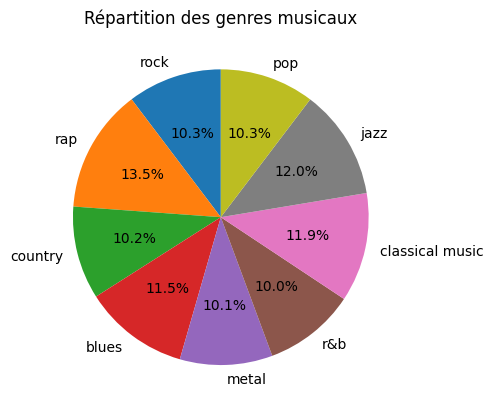

In [19]:
Dataset_Genres_bis = Dataset_Genres.copy()

for genre in final_genre_list:
    Dataset_Genres_bis[genre]= Dataset_Genres_bis['genre'].str.contains(genre, case=False).astype(bool).astype(int)
Dataset_Genres_bis.head(5)
genre_repartition = []
for genre in final_genre_list:
    acc = 0
    acc = Dataset_Genres_bis[genre].sum()
    genre_repartition.append(acc)

plt.pie(genre_repartition, labels=final_genre_list, autopct='%1.1f%%', startangle=90)
plt.title('Répartition des genres musicaux')
plt.show()

### __II. 2. Comprendre le lien entre les variables et les genres__

Ensuite, nous chercher à comprendre les liens entre nos variables et entre nos genres. Pour cela, nous traçons la matrice de corrélation de notre base de données numériques.

Text(0.5, 1.0, 'Matrice de corrélation')

<Figure size 640x480 with 0 Axes>

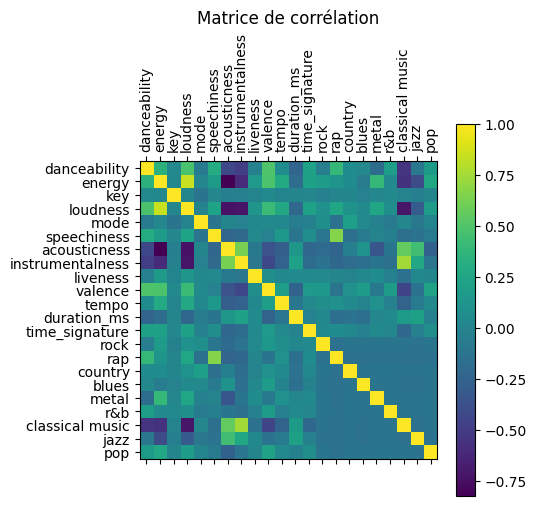

In [20]:
#matrice correlation avec les genres

Dataset_Genres_bis = Dataset_Genres_bis.drop(columns='genre')
f = plt.figure()

plt.matshow(Dataset_Genres_bis.corr())
plt.xticks(range(Dataset_Genres_bis.shape[1]), Dataset_Genres_bis.columns, rotation=90, fontsize= 10)
plt.yticks(range(Dataset_Genres_bis.shape[1]), Dataset_Genres_bis.columns, fontsize=10)

cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Matrice de corrélation')


On peut tirer de cette visualisation différentes observations.

D'abord, on remarque que energy est fortement correlée à loudness (positivement), acousticness et instrumentalness (négativement).
Ainsi, plus la musique bruyante, forte, plus elle est énergique. On pouvait s'y attendre. Plus la musique est instrumentale et acoustique, moins elle est énergique. On peut donc penser que l'énergie de la musique provient principalement de la présence d'un chanteur et d'instruments électriques.
Comme ces quatres variables sont correlées, nous pourrions en éluder pour gagner du temps lors des modélisations de machine learning.

Ensuite, on peut voir que le rap est le seul genre musical corrélé à speechiness (positivement). En effet, le rap est né de la volonté des chanteurs de dénoncer par les paroles, et aujourd'hui les rappeurs tentent de sortir du lot par leurs phrasés. Ainsi, il est logique que ce genre musical soit corrélé à speechiness. De plus, le fait que c'est le seul genre corrélé à cette variable nous laisse penser que ce genre musical sera bien reconnu par nos modèles de machine learning.

Nous observons également que classical music est fortement corrélé à instrumentalness (positivement). De plus, ce genre musical est aussi fortement corrélé à loudness (négativement). Ces résultats étaient attendus puisque la musique classique est un genre où la musique n'est jouée que par des instruments, sans chanteur, et où l'harmonie créée n'est généralement pas bruyante. Ce genre est le seul ayant ces propriétés fortes, à l'exception du jazz qui peut s'en rapprocher comme on le voit. Ainsi, nous pouvons attendre de nos modèles de machine learning une bonne détection de classical music, avec peut-être quelques errerus avec le jazz.

Enfin, les genres rock, r&b, pop, country et blues ne présentent pas de propriétés determinantes à vue d'oeil : nous anticipons donc que ces genres la serons sûrement moins identifiés.

Tentons d'observer certaines corrélations. D'abord obsverons la regression linéaire de Acousticness sur Loudness.

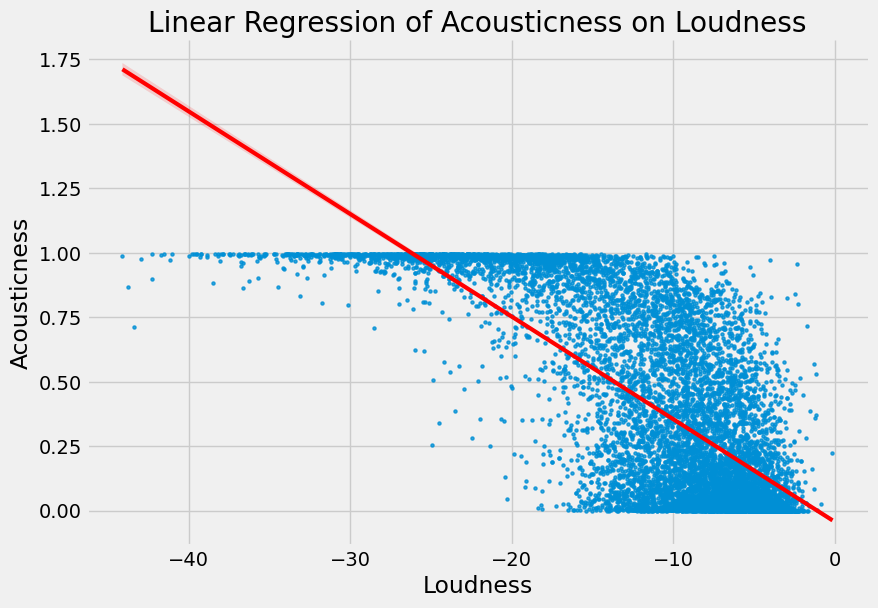

In [62]:
sns.lmplot(x='loudness', y='acousticness', data=Dataset_Genres, height=6, aspect=1.5, line_kws={'color': 'red', 'linewidth': 3}, scatter_kws={'s': 5})
plt.title('Linear Regression of Acousticness on Loudness')
plt.xlabel('Loudness')
plt.ylabel('Acousticness')

plt.show()

### __II. 3. Mettre en évidence ces relations__

Ensuite, il semble intéressant de regarder la répartition des valeurs prises par chaque variable selon les genres. Nous traçons donc des boxplot pour en voir les valeurs moyennes, les écarts à la moyennes et donc la répartition des valeurs pour chaque genre.



Camembert de la répartition des genres.

Pour chaque genre ; sortir Espérance, Variance ? dans histogramme

Pour chaque genre : faire une matrice des corrélations du dataset restreint au genre en particulier ?

Pour chaque genre : faire un graphe de telle variable en fonction de telle autre ?

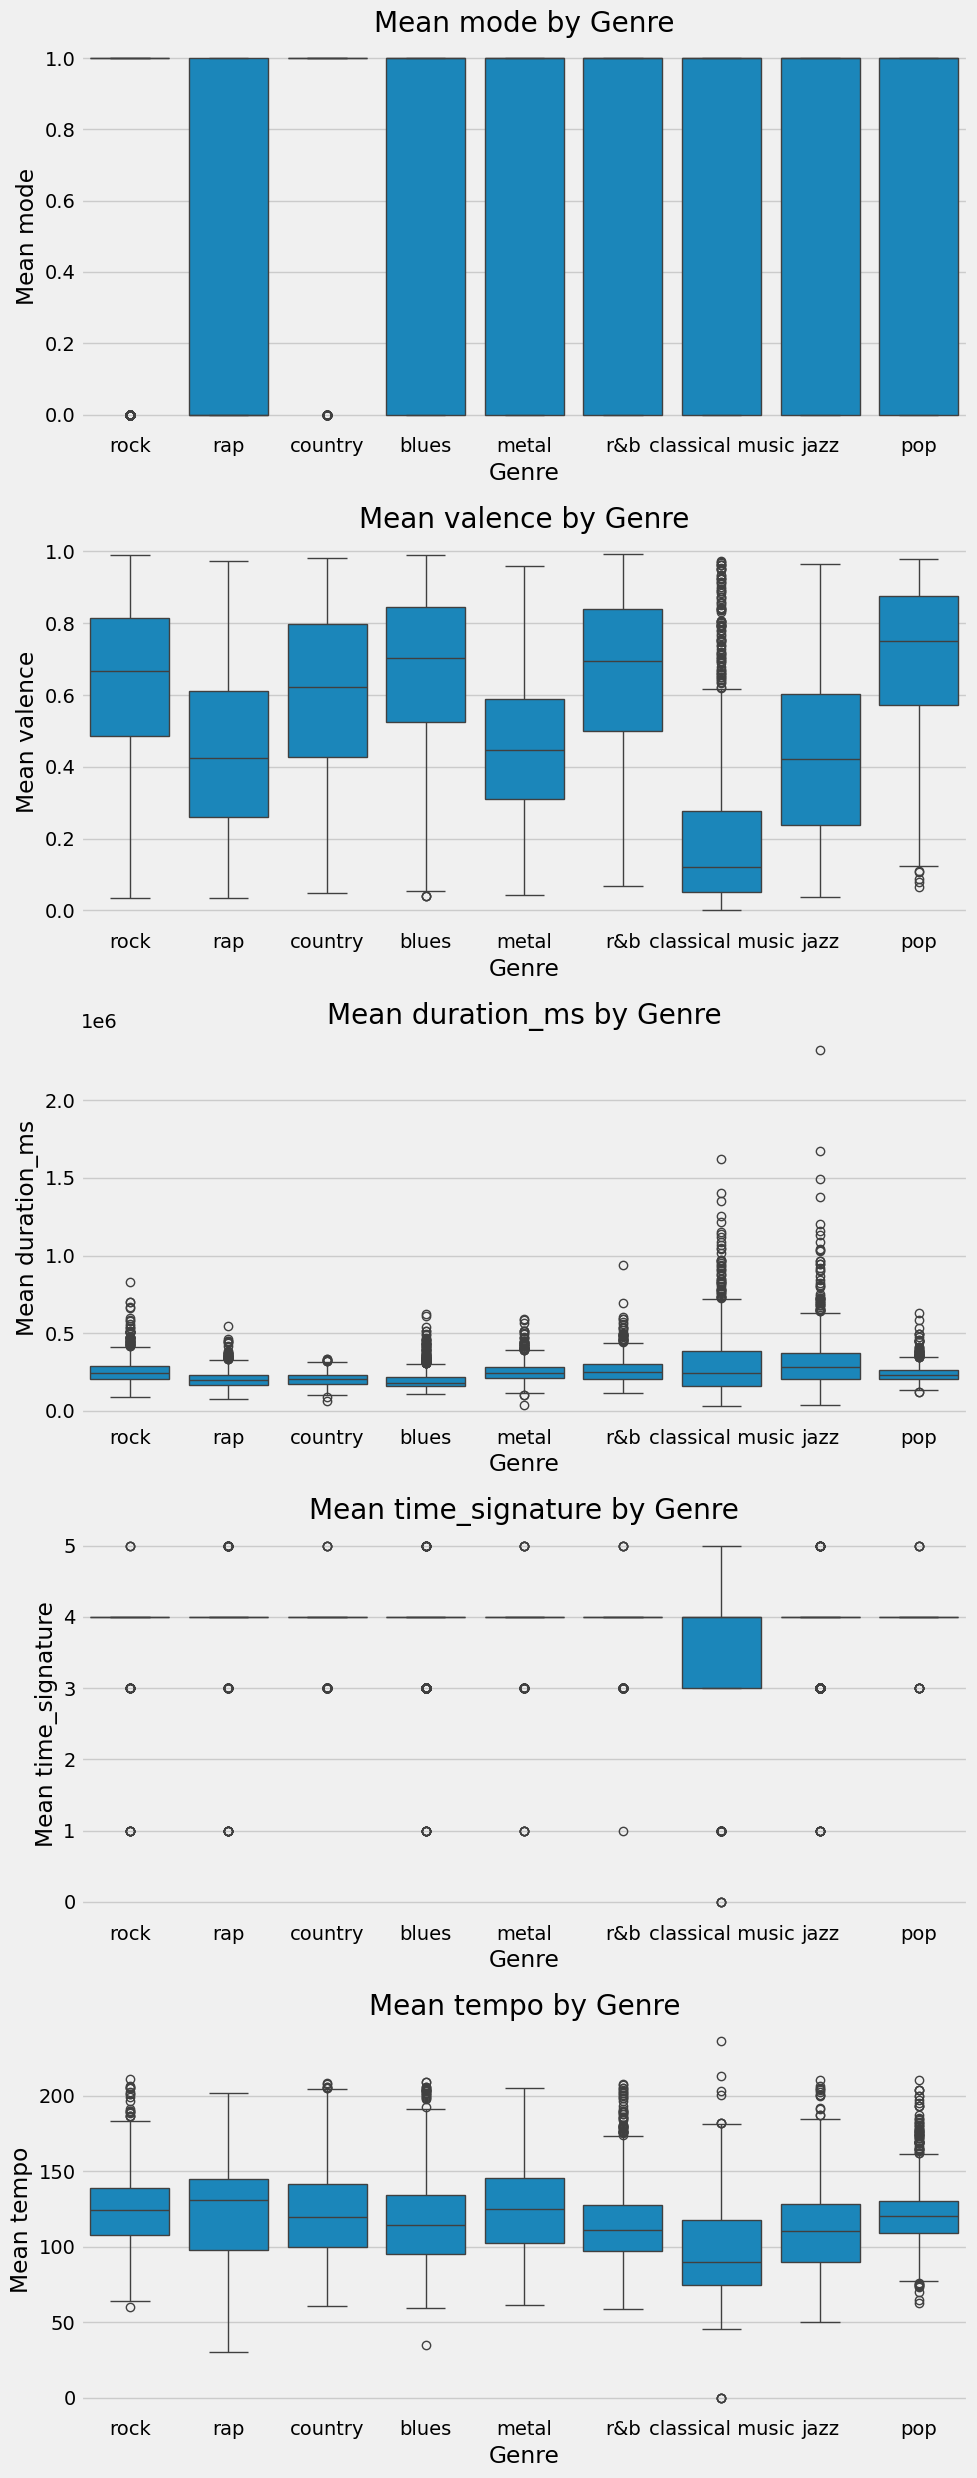

In [53]:
columns_to_show = ['mode', 'valence', 'duration_ms', 'time_signature', 'tempo']
columns_not_to_show = ['genre', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'energy', 'liveness']
fig, axes = plt.subplots(nrows=len(columns_to_show), ncols=1, figsize=(10, 5 * (len(columns_to_show))))

for i, col in enumerate(columns_to_show):
    if col in columns_to_show :
        sns.boxplot(x='genre', y=col, data=Dataset_Genres, ax=axes[i])
        axes[i].set_title(f'Mean {col} by Genre')
        axes[i].set_xlabel('Genre')
        axes[i].set_ylabel(f'Mean {col}')

plt.tight_layout()
plt.show()

Ici nous codons une fonction qui renvoie un graphe sur lequel ...

In [47]:
def boxplot_grouped_by(value_vars, df = Dataset_Genres, id_vars = ['genre']):
    melted_df = pd.melt(df, id_vars, value_vars, var_name='variable', value_name='value')

    # Create a boxplot for each variable, grouped by genre
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='variable', y='value', hue=id_vars[0], data=melted_df)
    plt.title(f"Boxplots for Selected Variables Across {id_vars[0]}")
    plt.xlabel('Variable')
    plt.ylabel('Value')

    plt.tight_layout()
    plt.show()


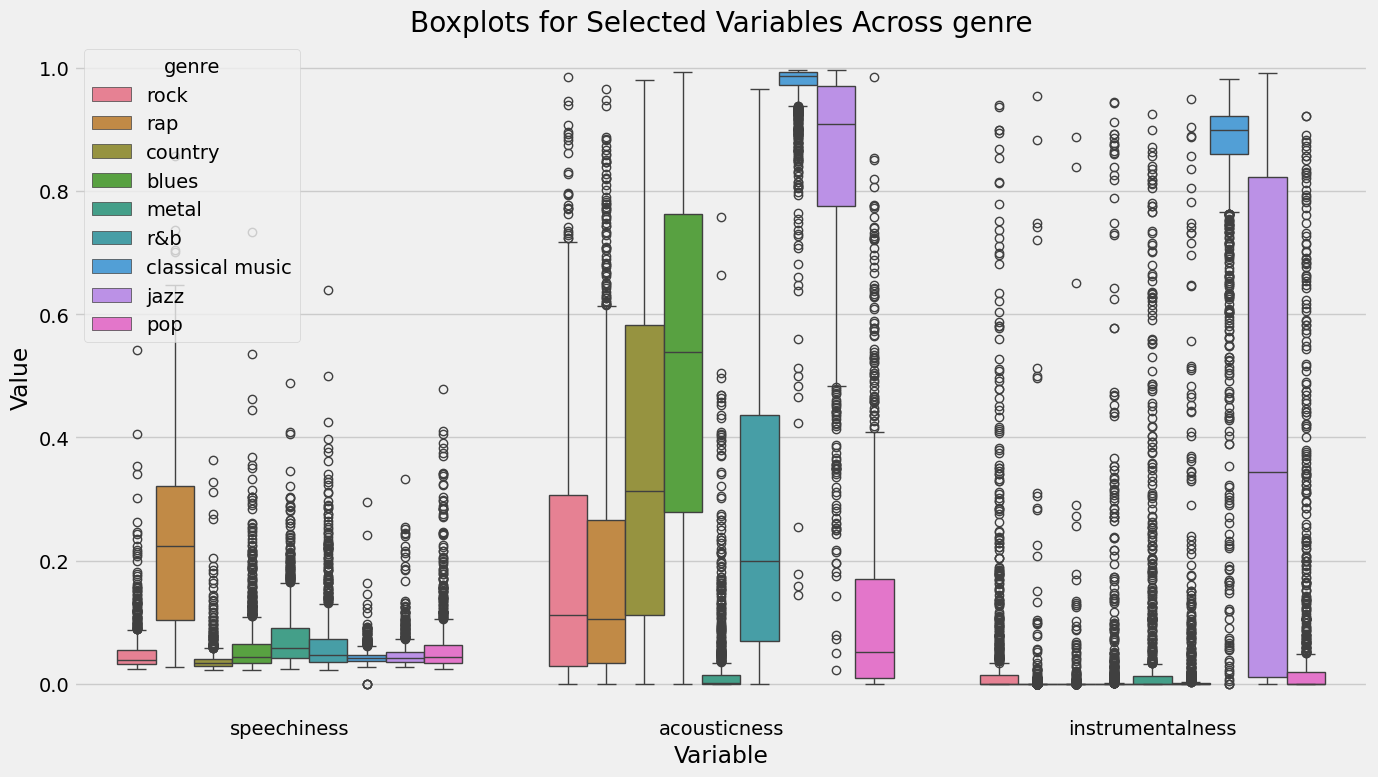

In [48]:
boxplot_grouped_by(['speechiness', 'acousticness', 'instrumentalness'])

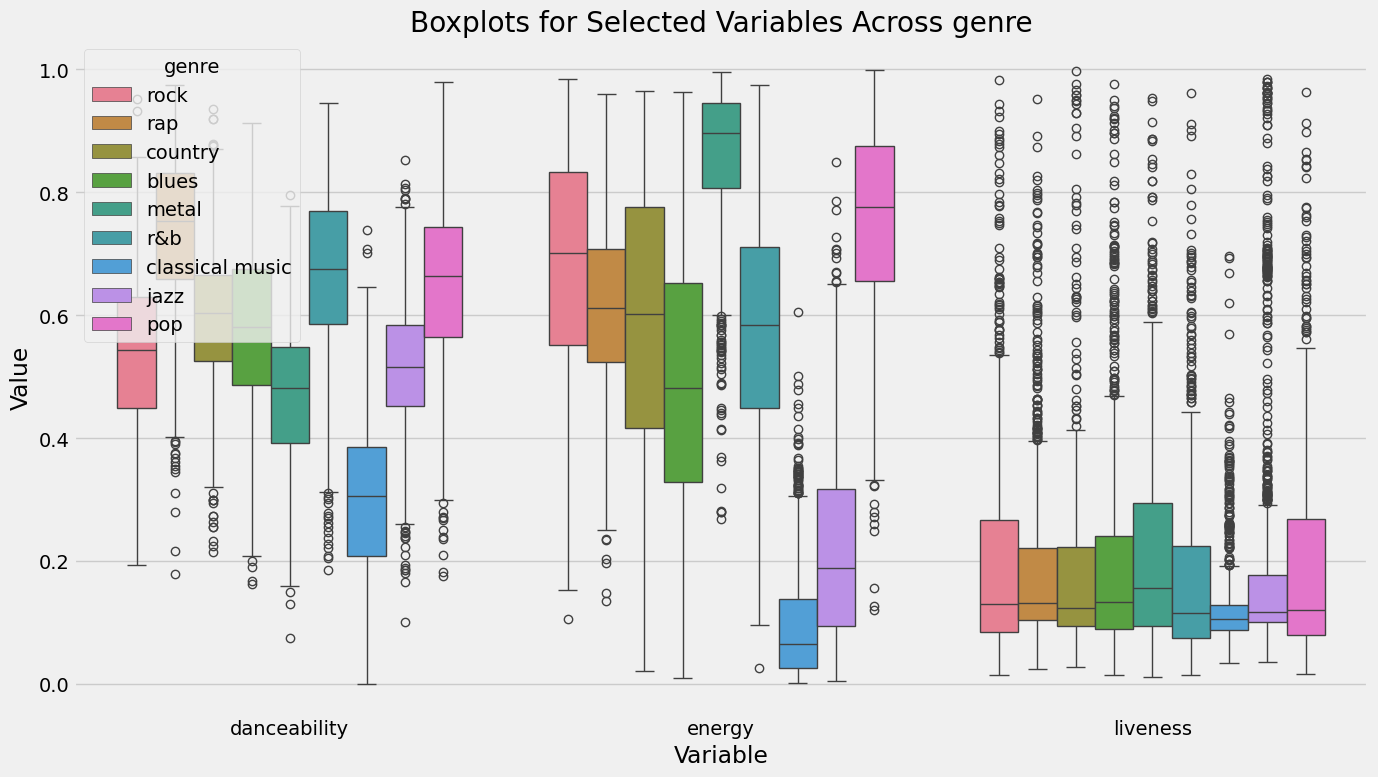

In [49]:
boxplot_grouped_by(['danceability', 'energy', 'liveness'])

In [21]:
y_acousticness = []
y_danceability = []
y_energy = []
y_instrumentalness = []
y_liveness = []
y_loudness = []
y_speechiness = []
y_tempo = []
y_valence = []

for genre in final_genre_list:
    Dataset_genre = Dataset_Genres.groupby(Dataset_Genres[genre])
    y_acousticness.append(Dataset_genre['acousticness'].mean()[1])
    y_danceability.append(Dataset_genre['danceability'].mean()[1])
    y_energy.append(Dataset_genre['energy'].mean()[1])
    y_instrumentalness.append(Dataset_genre['instrumentalness'].mean()[1])
    y_liveness.append(Dataset_genre['liveness'].mean()[1])
    y_loudness.append(Dataset_genre['loudness'].mean()[1])
    y_speechiness.append(Dataset_genre['speechiness'].mean()[1])
    y_tempo.append(Dataset_genre['tempo'].mean()[1])
    y_valence.append(Dataset_genre['valence'].mean()[1])

x = np.arange(len(final_genre_list))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width, y_acousticness, width, label='acousticness moyen', color='red', edgecolor = "black")
rects2 = ax.bar(x - 3*width/4, y_danceability, width, label='danceability moyen', color='blue', edgecolor = "black")
rects3 = ax.bar(x - width/2, y_energy, width, label='energy moyen', color='green', edgecolor = "black")
rects4 = ax.bar(x - width/4, y_instrumentalness, width, label='instrumentalness moyen', color='yellow', edgecolor = "black")
rects5 = ax.bar(x , y_liveness, width, label='liveness moyen', color='pink', edgecolor = "black")
rects6 = ax.bar(x + width/4, y_loudness, width, label='loudness moyen', color='purple', edgecolor = "black")
rects7 = ax.bar(x + width/2, y_speechiness, width, label='speechiness moyen', color='orange', edgecolor = "black")
rects8 = ax.bar(x + 3*width/4, y_tempo, width, label='tempo moyen', color='brown', edgecolor = "black")
rects9 = ax.bar(x + width, y_valence, width, label='valence moyen', color='grey', edgecolor = "black")
plt.grid(linestyle = "dashed", alpha = 0.5, color = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Caractéristiques moyennes par genre', fontsize= 20)
ax.set_xticks(x)
ax.set_xticklabels(final_genre_list, fontsize=16,  rotation=45)
ax.legend()

fig.tight_layout()

plt.show()

KeyError: 'rock'

# __III. Modélisation__

Pour répondre à notre problématique, nous implémentons deux modèles de machine learning : Random Forest et XGBoost.

Enfin, nous allons utiliser des modèles de machine learning pour prédire le genre d'une musique grâce aux variables dont nous disposons. Nous utilisons d'abord un modèle de type Random Forest, puis un modèle de type XGBoost, pour finalement comparer les deux.

Nous avons réalisé cette partie à partir des articles de Ilyes TALBI, Samir JEETO et Valentin DORE.

### __III. 1. Random Forest__


Tout d'abord, nous séparons la variable à prédire (le genre) des autres variables (les features). Ensuite, nous séparons ces ensembles en deux parties, l'une pour entraîner le modèle et l'autre pour tester le modèle. Comme notre base de données est ordonnée par genre, nous indiquons qu'il faut bisséquer aléatoirement cette base de données avec l'argument shuffle=True.

Nous pourrions enlever des variables puisque notre étape de visualisation a mis en évidence de fortes corrélations entre certaines d'entre elles. Cela ferait gagner du temps, pour un petit peu moins de précision. Nous avons choisi de garder toutes nos variables car le temps de calcul n'est pas très long.

In [22]:
features = Dataset_Genres.copy()

# isolation of the feature to predict
genres = np.array(features['genre'])
features = features.drop('genre', axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# separation in training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

# reshaping
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.transform(test_features)


Training Features Shape: (7389, 13)
Training Genres Shape: (7389,)
Testing Features Shape: (2464, 13)
Testing Genres Shape: (2464,)


Maintentant, nous allons procéder au tuning des hyper-paramètres.

In [23]:
rf = RandomForestClassifier(random_state = 0)

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


Il y a bien trop d'hyper-paramètres sur lesquels nous pouvons jouer. Nous choisissons de jouer sur le nombre d'arbres, la profondeur maximale des arbres, et le nombre minimal d'échantillons par noeuds.

Nous n'avons pas indiqué des poids pour chaque genre, car la base de données est relativement équilibrée. Pour améliorer le modèle, nous pourrions mettre des poids à chaque genre pour avoir une base de données parfaitement équilibrée.

Voici, les valeurs pour lesquelles nous allons tester les performances du modèle.

In [24]:
n_estimators = [1000, 2000, 4000]
max_depth = [20,None]
min_samples_split = [2, 4]

# creation of the grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
              }

pprint(random_grid)

{'max_depth': [20, None],
 'min_samples_split': [2, 4],
 'n_estimators': [1000, 2000, 4000]}


Nous faisons donc un random search avec ces différents hyper-paramètres et nous classons les différentes combinaisons d'hyper-paramètres par précision.

Nous voyons que les résultats sont meilleurs lorsqu'on fixe min_samples_split à 4 et min_samples_leaf à 1. De plus, nous observons de meilleurs résultats pour 2000 et 4000 arbres.

In [25]:
# creation of the model
rf = RandomForestClassifier(random_state = 0, max_features = 'sqrt', bootstrap = True)

# random search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 12, cv = 3, verbose=2, random_state=0, n_jobs = -1)

# fit
rf_random.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(rf_random.cv_results_["params"]),pd.DataFrame(rf_random.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(rf_random.best_params_)
print(pd_res.head)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[CV] END max_depth=20, min_samples_split=2, n_estimators=1000; total time=  24.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=1000; total time=  24.1s
[CV] END max_depth=20, min_samples_split=2, n_estimators=1000; total time=  24.7s
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time=  46.0s
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time=  46.1s
[CV] END max_depth=20, min_samples_split=4, n_estimators=1000; total time=  21.8s
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time=  46.8s
[CV] END max_depth=20, min_samples_split=4, n_estimators=1000; total time=  22.4s
[CV] END max_depth=20, min_samples_split=4, n_estimators=1000; total time=  21.3s
[CV] END max_depth=20, min_samples_split=4, n_estimators=2000; total time=  43.7s
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 1.5min
[CV] END max_depth=20, min_samples_split=4, n_estimators=2000; total time=  45.3s
[CV] END max_dep

/Users/clementgadeau/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_split=2, n_estimators=2000; total time=  51.8s
[CV] END max_depth=20, min_samples_split=4, n_estimators=4000; total time= 1.6min
[CV] END max_depth=None, min_samples_split=2, n_estimators=2000; total time=  47.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=2000; total time=  47.2s
[CV] END max_depth=None, min_samples_split=4, n_estimators=1000; total time=  24.3s
[CV] END max_depth=20, min_samples_split=4, n_estimators=4000; total time= 1.6min
[CV] END max_depth=None, min_samples_split=4, n_estimators=1000; total time=  21.7s
[CV] END max_depth=None, min_samples_split=4, n_estimators=1000; total time=  22.3s
[CV] END max_depth=None, min_samples_split=4, n_estimators=2000; total time=  42.9s
[CV] END max_depth=None, min_samples_split=2, n_estimators=4000; total time= 1.5min
[CV] END max_depth=None, min_samples_split=4, n_estimators=2000; total time=  44.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=4000; total time= 1.5

Après ces premiers résultats, nous fixons donc min_samples_split à 2, et nous continuons notre sélection d'hyper-paramètres (nombre d'arbres et profondeur maximale d'un arbre) grâce à un grid search. Il semble que 4000 arbres et une profondeur maximale de 20 soient les meilleurs valeurs, mais nous voulons vérifier avec ce grid search.

De même, nous classons les résultats obtenus par précision.

Compte tenu des résulats, nous fixons le nombre d'arbres à 4000, et nous choisissons de garder une profondeur maximale à 20 car il est risqué de fixer une trop grande profondeur (possible overfitting).

In [26]:
param_grid = {
    'max_depth': [20, None],
    'min_samples_split': [2],
    'n_estimators': [2000, 4000]
}
pprint(param_grid)

# création du modèle
rf = RandomForestClassifier(random_state = 0, bootstrap=True)

# grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)

{'max_depth': [20, None],
 'min_samples_split': [2],
 'n_estimators': [2000, 4000]}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time=  42.9s
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time=  43.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=2000; total time=  43.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=2000; total time=  43.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=2000; total time=  43.8s
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 1.5min
[CV] END max_depth=None, min_samples_split=2, n_estimators=2000; total time=  47.4s
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 1.5min
[CV] END max_depth=20, min_samples_split=2, n_estimators=4000; total time= 1.5min
[CV] END max_depth=None, min_samples_split=2, n_estimators=4000; total time= 1.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=4000; total time= 1.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=4000; total time= 1.3min
   m

Nous avons donc fini la partie du tuning des hyper-paramètres, et nous pouvons alors lancer le modèle.

In [27]:
# creation of the model
rf = RandomForestClassifier(n_estimators=4000, max_features='sqrt', max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, criterion='gini' ,random_state=0)

# fit
rf.fit(train_features, train_genres)

# prédictions
predictions = rf.predict(test_features)

# Zero_one_loss error
errors = zero_one_loss(test_genres, predictions, normalize=True)
print('zero_one_loss error normalized:', errors)

# Accuracy Score
accuracy_test = accuracy_score(test_genres, predictions)
print('accuracy_score on test dataset :', accuracy_test)

print(classification_report(predictions, test_genres))

zero_one_loss error normalized: 0.34172077922077926
accuracy_score on test dataset : 0.6582792207792207
                 precision    recall  f1-score   support

          blues       0.58      0.53      0.55       316
classical music       0.94      0.92      0.93       312
        country       0.59      0.60      0.60       242
           jazz       0.81      0.79      0.80       321
          metal       0.79      0.68      0.73       260
            pop       0.36      0.46      0.40       202
            r&b       0.35      0.45      0.40       196
            rap       0.93      0.83      0.88       370
           rock       0.43      0.42      0.42       245

       accuracy                           0.66      2464
      macro avg       0.64      0.63      0.63      2464
   weighted avg       0.68      0.66      0.67      2464



Nous obtenons une précision de 66% ce qui est satisfaisant !

On remarque que les genres les mieux prédits sont bien classical music et rap, comme nous l'avions attendu grâce à notre étape de visualisation. De plus, les genres rock, r&b et encore pop sont moins bien identifés comme nous l'attendions également.

Nous traçons la matrice de confusion pour visualiser les différentes erreurs.

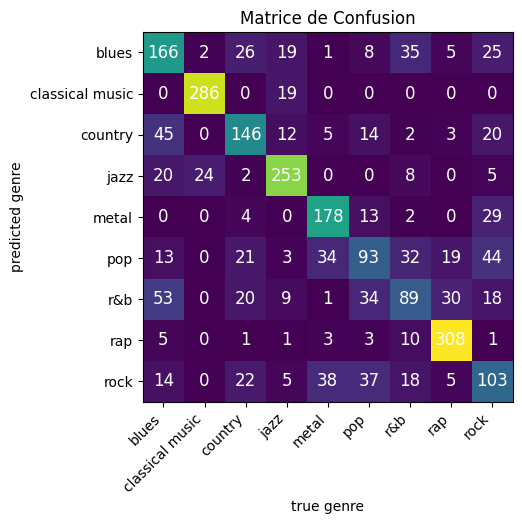

In [28]:
#Confusion matrix

mat = confusion_matrix(test_genres, predictions)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
#plt.colorbar(label='Valeurs')
plt.title('Matrice de Confusion')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['blues','classical music','country','jazz','metal','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Grâce à la matrice des confusions, nous pouvons voir par exemple que les musiques classiques sont bien classés, sauf quelques unes qui sont évaluées comme des musiques jazz : c'est exactement ce que notre étape de visualisation avait annoncé !



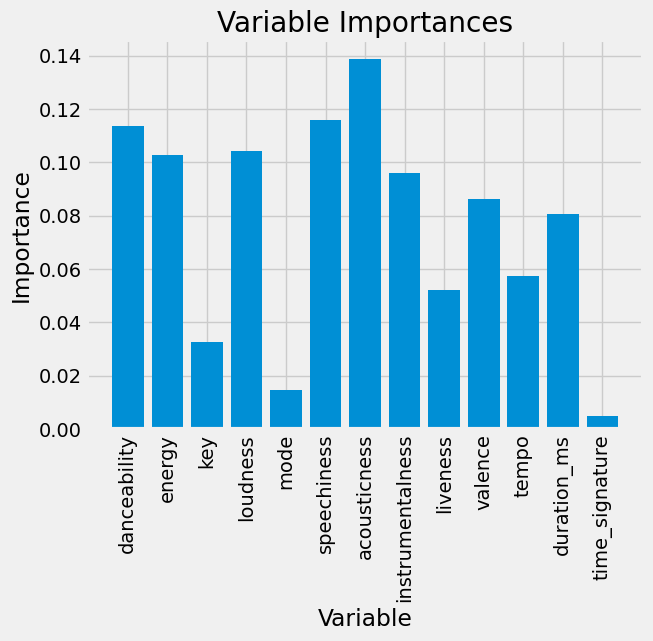

In [29]:
#Feature importances
plt.style.use('fivethirtyeight')

importances = list(rf.feature_importances_)

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show()

Enfin, nous traçons ici l'importance de chaque variable. Nous observons que key, mode et time_signature ne sont pas très utiles à la prédiction. Nous pouvions nous y attendre puisque ce sont des variables qui varient relativement peu, et qui sont décorrélées de chaque genre.

Ainsi, notre modélisation Random Forest permet de prédire un genre musical avec une précision de 66%, ce qui est satisfaisant, mais en réalité elle identifie mal les genres pop et rock qui sont très représentés dans le monde de la musique, tandis qu'elle identifie bien le genre classical music, qui n'est pas le genre le plus écouté de nos jours.

### __III. 2. XGBoost__

Nous utilisons maintenant le modèle XGBoost. Ici, nous attribuons à chaque genre une valeur numérique (entre 0 et 8) pour pouvoir utiliser ce modèle.

Nous procédons de la même manière que précédemment.

In [30]:
features = Dataset_Genres.copy()

def genre_to_num(genre):
    if genre == 'rock':
        return 8
    if genre == 'rap':
        return 7
    if genre == 'r&b':
        return 6
    if genre == 'pop':
        return 5
    if genre == 'metal':
        return 4
    if genre == 'jazz':
        return 3
    if genre == 'country':
        return 2
    if genre == 'classical music':
        return 1
    if genre == 'blues':
        return 0
features['genre'] = features['genre'].apply(genre_to_num)

# isolation of the feature to predict
genres = np.array(features['genre'])
features = features.drop('genre', axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# separation in training and testing sets
train_features, test_features, train_genres, test_genres = train_test_split(features, genres, test_size = 0.25, random_state = 0, shuffle = True)
print('Training Features Shape:', train_features.shape)
print('Training Genres Shape:', train_genres.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Genres Shape:', test_genres.shape)

Training Features Shape: (7389, 13)
Training Genres Shape: (7389,)
Testing Features Shape: (2464, 13)
Testing Genres Shape: (2464,)


Nous commençons par une phase de tuning des hyper-paramètres. Regardons sur quels paramètres nous pouvons jouer.

In [31]:
clf = XGBClassifier(objective= 'multi:softprob', random_state = 42)
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'multi:softprob',
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


Il y en une multitude : nous sélectionnons seulement max_depth (la profondeur maximale d'un arbre) et n_estimators (le nombre d'arbres).
Voici les valeurs pour lesquelles nous allons tester la précision du modèle.

In [32]:
random_grid = {
    "gamma" : [0],
    "learning_rate" : [0.1],
    "max_depth" : [20, None],
    "n_estimators" : [100, 200, 300, 400, 500], 
    "subsample" : [0.8]}

pprint(random_grid)

{'gamma': [0],
 'learning_rate': [0.1],
 'max_depth': [20, None],
 'n_estimators': [100, 200, 300, 400, 500],
 'subsample': [0.8]}


Nous faisons donc un random search avec ces différentes valeurs, et nous affichons la précision obtenue pour chacune des combinaisons possibles.

In [33]:
# création du modèle
clf = XGBClassifier(objective= 'multi:softprob', random_state=42)

# random search
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)

# fit le modèle
clf_random.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(clf_random.cv_results_["params"]),pd.DataFrame(clf_random.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=100, subsample=0.8; total time=  10.6s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=100, subsample=0.8; total time=  10.7s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=100, subsample=0.8; total time=  11.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=200, subsample=0.8; total time=  15.0s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=200, subsample=0.8; total time=  15.0s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=200, subsample=0.8; total time=  15.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=300, subsample=0.8; total time=  17.2s
[CV] END gamma=0, learning_rate=0.1, max_depth=20, n_estimators=300, subsample=0.8; total time=  17.9s
[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, subsample=0.8; total time=   4.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=None, n_estimators=100, 

Nous choisissons de fixer max_depth à 20 pour éviter l'overfitting, mais si cela semble être moins précis.
Pour bien choisir le nombre d'arbres, nous faisons un grid search. Voici les valeurs pour lesquelles nous faisons ce grid search.

In [34]:
param_grid = {
    "learning_rate" : [0.1], #d0.3
    "max_depth"        : [20], #d6
    "n_estimators" : [100, 200, 300], #d100
    "subsample" : [0.8], #d1
}

pprint(param_grid)

{'learning_rate': [0.1],
 'max_depth': [20],
 'n_estimators': [100, 200, 300],
 'subsample': [0.8]}


Nous lançons donc le grid search et compte tenu des résultats, nous garder la valeur de 100 arbres pour notre modèle final.

In [35]:
clf = XGBClassifier(objective= 'multi:softprob', random_state = 0)

grid = GridSearchCV(clf, param_grid = param_grid, n_jobs=-1, scoring="accuracy", cv=3) #scoring="neg_log_loss"
grid.fit(train_features, train_genres)

pd_res = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
pd_res = pd_res.sort_values('Accuracy', ascending=False)
print(pd_res)

   learning_rate  max_depth  n_estimators  subsample  Accuracy
2            0.1         20           300        0.8  0.647314
0            0.1         20           100        0.8  0.646637
1            0.1         20           200        0.8  0.644742


Nous lançons donc notre modèle final avec les hyper-paramètres tunés.

In [36]:
# model
model_xgb = XGBClassifier(objective='multi:softprob', colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=20, min_child_weight=1, n_estimators=100, subsample=0.8, random_state = 42)

# fit the model with the training data
model_xgb.fit(train_features, train_genres)

# predict the target on the test dataset
predict_test = model_xgb.predict(test_features)
 
# Accuracy Score on test dataset
accuracy_test = accuracy_score(test_genres, predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)
print(classification_report(predict_test, test_genres))


accuracy_score on test dataset :  0.658685064935065
              precision    recall  f1-score   support

           0       0.55      0.50      0.52       312
           1       0.93      0.93      0.93       306
           2       0.60      0.60      0.60       247
           3       0.84      0.81      0.82       324
           4       0.76      0.69      0.72       251
           5       0.38      0.45      0.42       218
           6       0.39      0.48      0.43       207
           7       0.91      0.85      0.88       357
           8       0.41      0.41      0.41       242

    accuracy                           0.66      2464
   macro avg       0.64      0.64      0.64      2464
weighted avg       0.67      0.66      0.66      2464



Nous obtenons aussi une précision de 66% (légèrement supérieur à celle de random forest ce qui est peu surprenant).

Nous pouvons faire les mêmes observations que précedemment. De plus, la matrice de confusion est très similaire à la précédente.

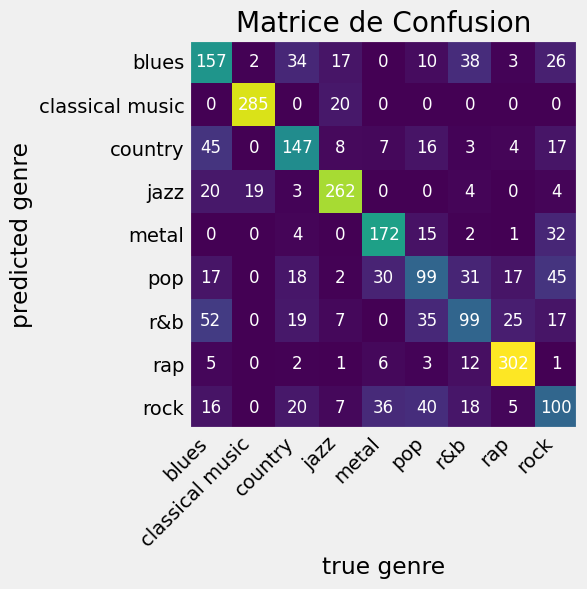

In [37]:
#Matrice de confusion
mat = confusion_matrix(test_genres, predict_test)
plt.imshow(mat, cmap='viridis', interpolation='nearest')
#plt.colorbar(label='Valeurs')
plt.title('Matrice de Confusion')
num_rows, num_cols = mat.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.text(j, i, str(mat[i, j]), ha='center', va='center', color='w', fontsize=12)
plt.grid(False)
genres_list = ['blues','classical music','country','jazz','metal','pop','r&b','rap','rock']
plt.xticks(np.arange(num_cols), genres_list, rotation=45, ha='right')
plt.yticks(np.arange(num_rows), genres_list)
plt.xlabel('true genre')
plt.ylabel('predicted genre')
plt.show()

Finalement, les deux modèles, Random Forest et XGBoost nous donnent des résultats très similaires : nous pouvons prédire le genre d'une musique grâce aux données dispoinbles sur Spotify avec une précision de 66%. Nous prédisons bien le rap et la musique classique, mais moins bien le rock et la pop.

# ___Conclusion___

### SOURCE


https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features

https://pythonds.linogaliana.fr/

https://larevueia.fr/machine-learning-pour-la-classification-automatique-de-musiques-avec-python/